In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
%matplotlib inline

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
import math 
import ast
from tabulate import tabulate
from scipy.stats.stats import pearsonr
from scipy.stats import mode

def split_line(line):
    params = ast.literal_eval(line)
    loss = params['loss']
    auc = params['auc']
    return [loss, auc, params]


def parse_file(files, sort_by_loss=True):
    results = []
    
    for filename in files:
        with open(filename, 'r') as fp:
            for line in fp:
                results.append(split_line(line.strip()))

    if sort_by_loss:
        results = sorted(results)
    else:
        results = sorted(results, key=lambda x: -x[1])

    C = []
    gamma = []
    loss = []
    auc = []
    for result in results:
        loss.append(result[0])
        auc.append(result[1])
        C.append(result[2]['C'])
        gamma.append(result[2]['gamma'])
        
    loss = np.array(loss)
    auc = np.array(auc)
    C = np.array(C)
    gamma = np.array(gamma)
      
    results = {
        'loss': loss,
        'auc': auc,
        'C': C,
        'gamma': gamma
    }
    
    print('')
    return results


def results_stats(results, top=1, relative=True):
    headers = ['metric', 'min', 'max', 'median', 'mean', 'std']    
    results_stats = []
    results_logstats = []
    
    top_results = dict()
    for i, key in enumerate(results):
        arr = results[key]
        if relative:
            idx = math.ceil(top*len(arr))
        else:
            idx = top
        arr = arr[:idx]
        top_results[key] = arr
        results_stats.append([key, arr.min(), arr.max(), np.median(arr), arr.mean(), arr.std()])
        
        if i == 0:
            samples = len(arr)
        
        if key in log_metrics:
            logarr = np.log2(arr)
            results_logstats.append([key, logarr.min(), logarr.max(), 
                                     np.median(logarr), logarr.mean(), logarr.std()])
            
    print('# samples = %d/%d' % (samples, len(results[key])))
    print (tabulate(results_stats, headers=headers, numalign="right", floatfmt=".10f"))
    print('\n\nlog metrics')
    print (tabulate(results_logstats, headers=headers, numalign="right", floatfmt=".10f"))
    
    return results_stats, top_results


def plot_hist(results):
    plt.figure(figsize=(12, 12))
    ncol = 3
    nrow = math.ceil(len(results) / ncol) 
        
    for i, key in enumerate(results):
        plt.subplot(nrow, ncol, i + 1)
        if key in log_metrics:
            arr = np.log2(results[key])
            label = 'log' + key
        else:
            arr = results[key]
            label = key
        
        max = arr.max()
        min = arr.min()
        bins = np.linspace(min, max, 15)
        plt.hist(arr, bins=bins)
        plt.xlabel(label)
        plt.ylabel('freq')
        
        
def print_best(results, k=1):
    best_result = []
    headers = []
    
    for i in range(k):
        best_result.append([])
        for key in results:
            if key in log_metrics:
                best_result[-1] += [np.log2(results[key][i])]
                if i == 0:
                    headers += ['log' + key]
            else:
                best_result[-1] += [results[key][i]]
                if i == 0:
                    headers += [key]

    print('\nbest models')
    print (tabulate(best_result, headers=headers, numalign="right", floatfmt=".6f"))
    print()
    
    
def plot_scatter(results, metric='loss'):
    plt.figure(figsize=(15, 10))
    ncol = 1
    nrow = 2 
    
    count = 1
    for key in results:
        if key not in ['auc', 'loss']:
            plt.subplot(nrow, ncol, count)
            if key in log_metrics:
                arr = np.log2(results[key])
                label = 'log' + key
            else:
                arr = results[key]
                label = key

            plt.scatter(arr, results[metric])
            plt.xlabel(label)
            plt.ylabel(metric)
            count += 1
        
        
def get_model_name(results, top=5):
    names = []
    for i in range(top):
        name = 'model.' \
            + 'auc:%.6f.' % results['auc'][i] \
            + 'lr:%.6f.' % results['lr'][i] \
            + 'reg:%.6f.' % results['reg'][i] 
        names += [name]
        
    return names


def compare_plots(results, keys, top=10):
    plt.figure(figsize=(15, 6))
    marker_size = 20
    
    # loss
    plt.subplot(1, 2, 1)
    colors = results['loss'][:top]
    x_scatter = results[keys[0]][:top]
    xlabel = keys[0]
    if keys[0] in log_metrics:
        x_scatter = np.log2(x_scatter)
        xlabel = 'log' + xlabel
    
    y_scatter = results[keys[1]][:top]
    ylabel = keys[1]
    if keys[1] in log_metrics:
        y_scatter = np.log2(y_scatter)
        ylabel = 'log' + ylabel
    
    plt.scatter(x_scatter, y_scatter, marker_size, cmap='inferno', c=colors)
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('loss')
    
    # auc
    plt.subplot(1, 2, 2)
    colors = results['auc'][:top]
    plt.scatter(x_scatter, y_scatter, marker_size, cmap='inferno', c=colors)
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('auc')

    
def topology_hist(results, metric='loss'):
    keys = ['width', 'length']
    plt.figure(figsize=(16, 6))
    max = results[metric].max()
    min = results[metric].min()
    bins = np.linspace(min, max, 7)    
    for i, key in enumerate(keys):
        for value in np.unique(results[key]):
            plt.subplot(1, 2, i + 1)
            plt.hist(results[metric][results[key] == value], label=key+'='+str(value), bins=bins)
        plt.xlabel(metric)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=5, fancybox=True, shadow=True)
        plt.xlim([0.99*min, 1.01*max])
        
        if i == 0:
            plt.ylabel('freq')
            
log_metrics = ['C', 'gamma']

In [3]:
files = ['../svm_results.log']   
results = parse_file(files, sort_by_loss=False)

top = 20
print('Correlation loss x AUC: (%.6f, %.6e)' % pearsonr(results['auc'], results['loss']))
print_best(results, top)
_, top_results = results_stats(results, top, relative=False)


Correlation loss x AUC: (-0.652056, 9.710543e-21)

best models
    loss       auc       logC    loggamma
--------  --------  ---------  ----------
0.004176  0.980753  -1.000000  -10.000000
0.004410  0.980572  -3.000000   -9.000000
0.004797  0.980392  -4.000000   -7.000000
0.004544  0.980376  -2.000000  -10.000000
0.004382  0.980333  -4.000000   -8.000000
0.004740  0.980263  -5.000000   -7.000000
0.004897  0.980118  -6.000000   -7.000000
0.004661  0.980110  -5.000000   -8.000000
0.004783  0.979945  -3.000000   -7.000000
0.004794  0.979642  -4.000000   -9.000000
0.004492  0.979414  -2.000000   -8.000000
0.004984  0.978989  -6.000000   -8.000000
0.004686  0.978971  -3.000000  -10.000000
0.005148  0.978923  -7.000000   -7.000000
0.004993  0.978880  -8.000000   -8.000000
0.004944  0.978843  -6.000000   -6.000000
0.004772  0.978836  -5.000000   -6.000000
0.004895  0.978810  -7.000000   -8.000000
0.004725  0.978758  -2.000000   -7.000000
0.004666  0.978653  -5.000000  -10.000000

# samples =

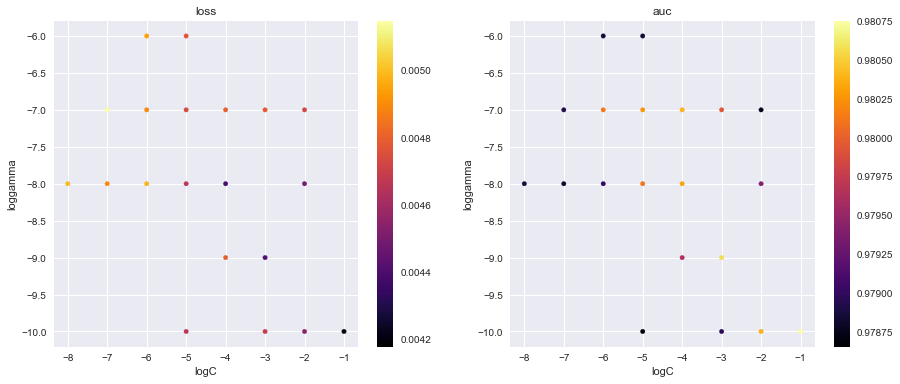

In [4]:
compare_plots(results, ['C', 'gamma'], top)

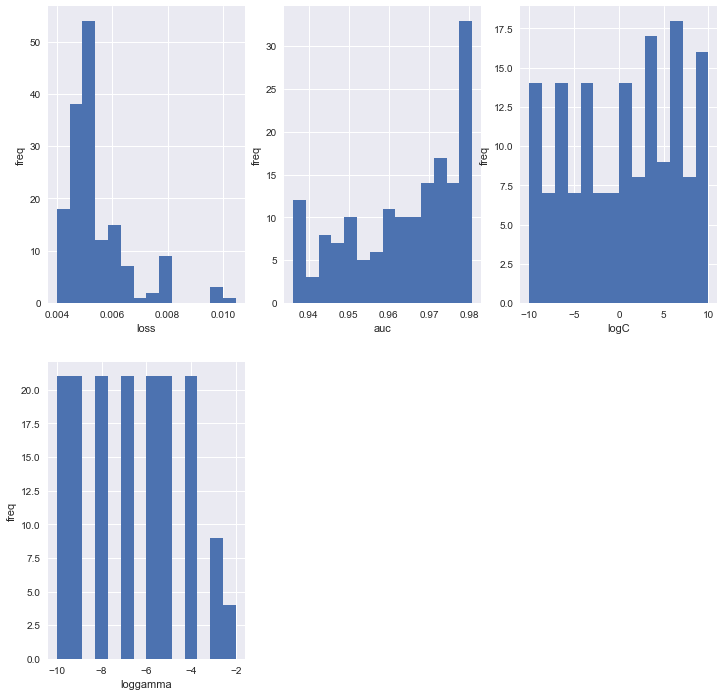

In [5]:
plot_hist(results)

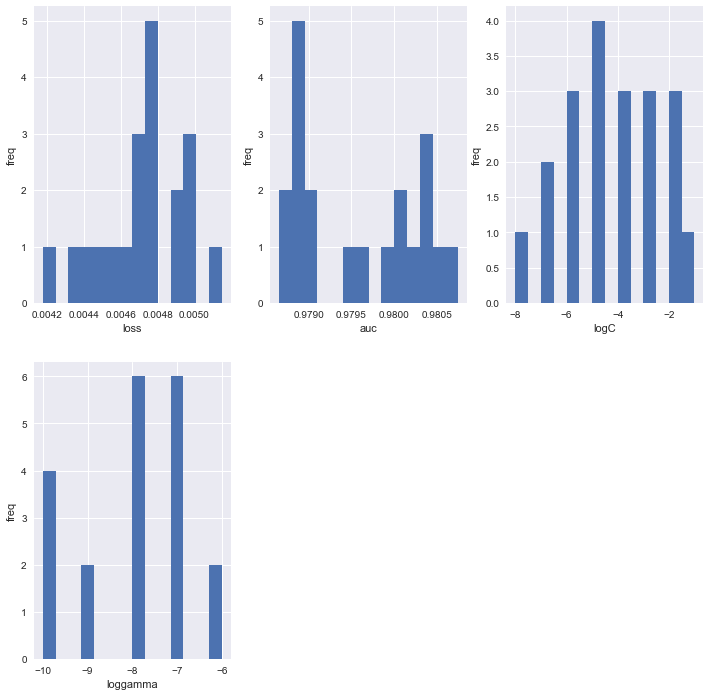

In [6]:
plot_hist(top_results)

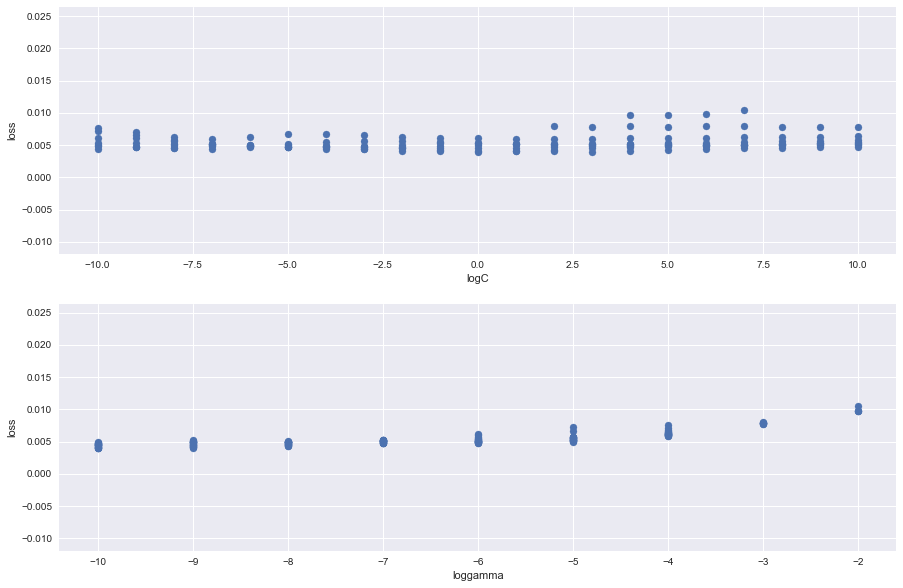

In [7]:
plot_scatter(results, 'loss')

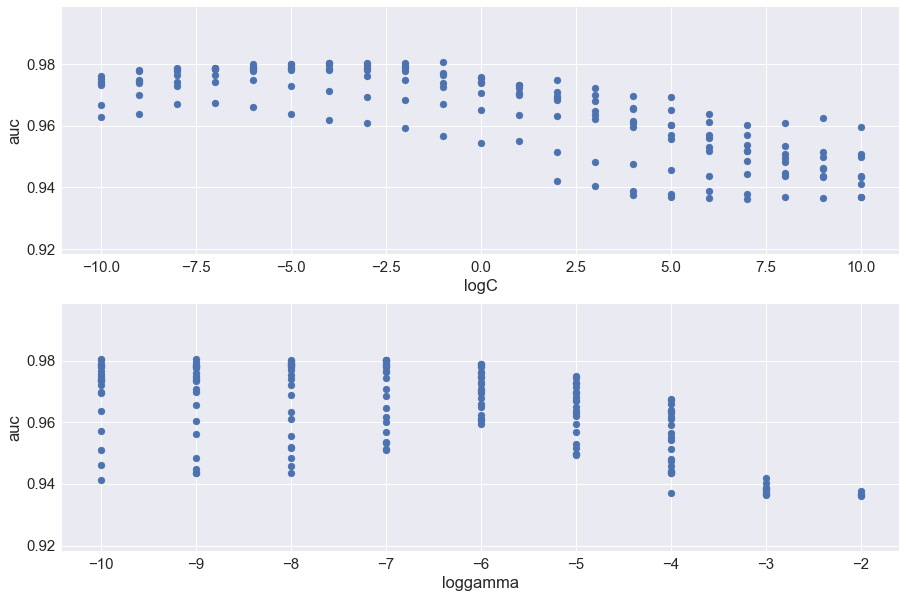

In [8]:
sns.set(font_scale=1.5)
plot_scatter(results, 'auc')